In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from scipy.optimize import minimize


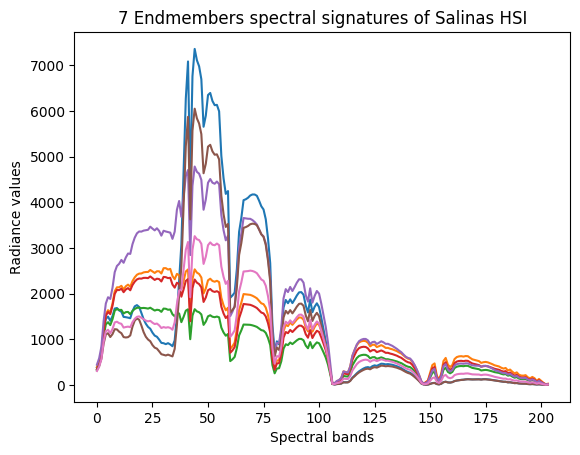

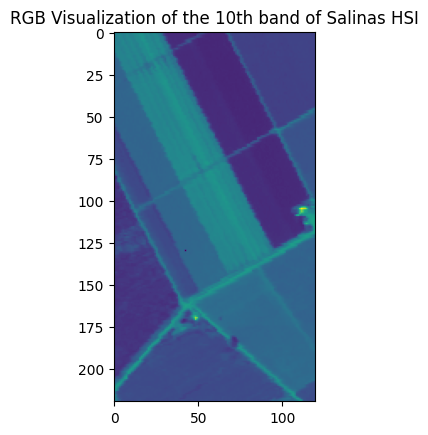

In [2]:
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

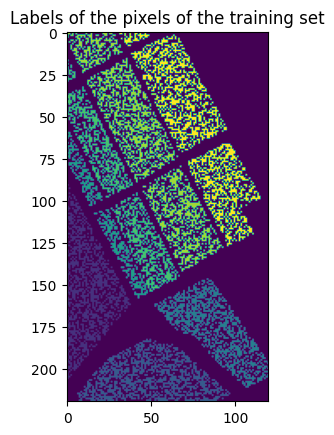

In [3]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [4]:
# Least Squares estimate (Vanilla)
def least_squares(X, y):
    theta, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    return theta

In [5]:
# Least Squares estimate with sum-to-one constraint
def least_squares_sum_to_one(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess
    theta0 = np.ones(n) / n
    
    # Constraint: sum of coefficients = 1
    constraint = {'type': 'eq', 'fun': lambda theta: np.sum(theta) - 1}
    
    # Solve
    result = minimize(objective, theta0, constraints=[constraint], method='SLSQP')
    return result.x

In [6]:
#  Least Squares estimate with non-negativity constraint
def least_squares_nonneg(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess (all positive)
    theta0 = np.ones(n) * 0.1
    
    # Bounds: all parameters >= 0
    bounds = [(0, None) for _ in range(n)]
    
    # Solve
    result = minimize(objective, theta0, bounds=bounds, method='L-BFGS-B')
    return result.x

In [7]:
# Least Squares estimate with non-negativity and sum-to-one constraints
def least_squares_nonneg_sum_to_one(X, y):
    n = X.shape[1]
    
    # Objective function: ||X*theta - y||^2
    def objective(theta):
        return np.sum((X @ theta - y) ** 2)
    
    # Initial guess (uniform positive summing to 1)
    theta0 = np.ones(n) / n
    
    # Bounds: all parameters >= 0
    bounds = [(0, None) for _ in range(n)]
    
    # Constraint: sum of coefficients = 1
    constraint = {'type': 'eq', 'fun': lambda theta: np.sum(theta) - 1}
    
    # Solve
    result = minimize(objective, theta0, bounds=bounds, constraints=[constraint], method='SLSQP')
    return result.x

In [8]:
def lasso(X, y, alpha=1.0):
    model = Lasso(alpha=alpha, fit_intercept=False)
    model.fit(X, y)
    return model.coef_

In [9]:
def unmix_matrix(endmembers, HSI, labels, method="Least Squares"):
    height, width = labels.shape
    X = endmembers
    n_endmembers = endmembers.shape[1]
    total_error = 0
    pixel_count = 0
    abundance_map = np.zeros((height,width,n_endmembers))

    for i in range(height):
        for j in range(width):
            if labels[i,j] != 0:
                y = HSI[i,j,:]

                if method == "Least Squares":
                    theta = least_squares(X, y)
                elif method == "Least Squares Sum-to-One":
                    theta = least_squares_sum_to_one(X, y)
                elif method == "Least Squares Non-Negative":
                    theta = least_squares_nonneg(X, y)
                elif method == "Least Squares Non-Negative Sum-to-One":
                    theta = least_squares_nonneg_sum_to_one(X, y)
                elif method == "Lasso":
                    theta = lasso(X, y)
                else:
                    raise ValueError("Invalid method")

                abundance_map[i,j,:] = theta

                reconstructed = X @ theta
                error = np.sum((y - reconstructed)**2)
                total_error += error
                pixel_count += 1

    avg_error = total_error / pixel_count if pixel_count > 0 else 0

    return abundance_map, avg_error

In [10]:
def plot_abundance_map(abundance_map, labels,  materials):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 8 maps
    axes = axes.ravel()  # Flatten axes for easier indexing
    
    estimated_labels = np.argmax(abundance_map, axis=2) + 1  # Convert 0-based index to 1-7
    error_map = (labels != estimated_labels).astype(int)  # 1 where there's a mismatch

    for i in range(7):
        im = axes[i].imshow(abundance_map[:, :, i])
        axes[i].set_title(f'{materials[i]}')
        plt.colorbar(im, ax=axes[i])
    
    im = axes[7].imshow(error_map, cmap='Reds', interpolation='nearest')
    axes[7].set_title("Error Map")
    # Create custom legend handles for 'Red' and 'White'
    red_patch = mpatches.Patch(color='red', label='Incorrect')
    white_patch = mpatches.Patch(color='white', label='Correct')

    # Add the legend
    axes[7].legend(handles=[red_patch, white_patch], loc='upper right')    
    im = axes[8].imshow(Training_Set)
    axes[8].set_title('Label Map (Ground Truth)')
    cbar = plt.colorbar(im, ticks=np.arange(1, len(materials) + 1))
    cbar.set_label("Cluster")
    cbar.set_ticklabels(materials)
    plt.show()
    
    plt.show()

In [11]:
# List of materials
materials = ['Grapes', 'Broccoli', 'Fallow 1', 'Fallow 2', 'Fallow 3', 'Stubble', 'Celery']

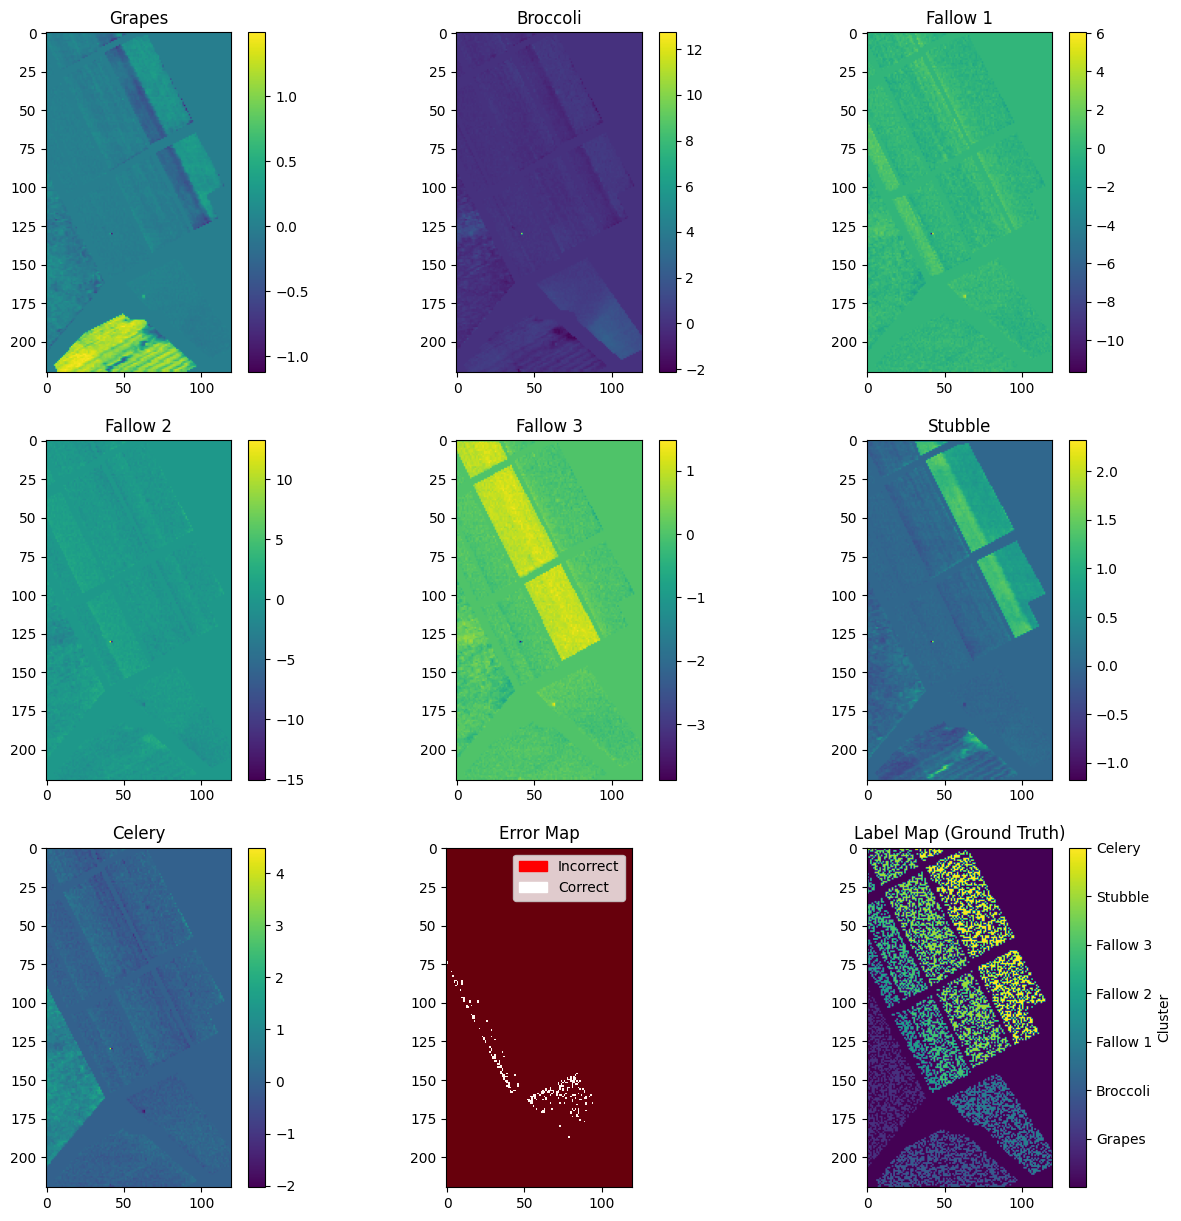

In [17]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels)
plot_abundance_map(abundance_map, labels, materials)
# print(f"Average Reconstruction Error: {reconstruction_error}")

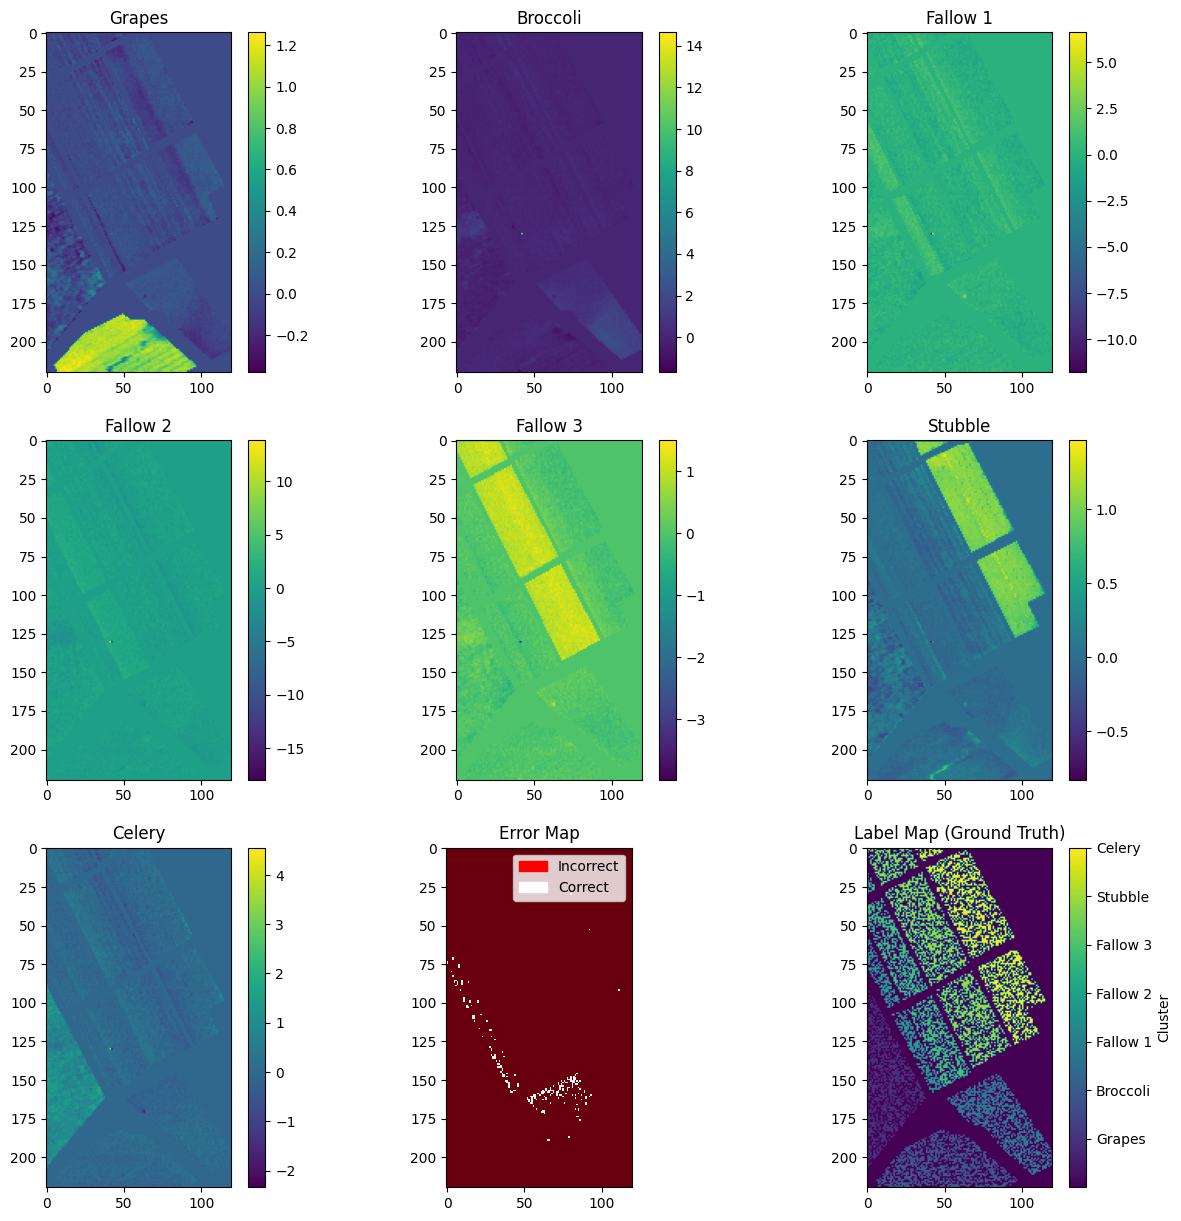

Average Reconstruction Error: 43082.57630023894


In [13]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Sum-to-One")
plot_abundance_map(abundance_map, labels, materials)
print(f"Average Reconstruction Error: {reconstruction_error}")

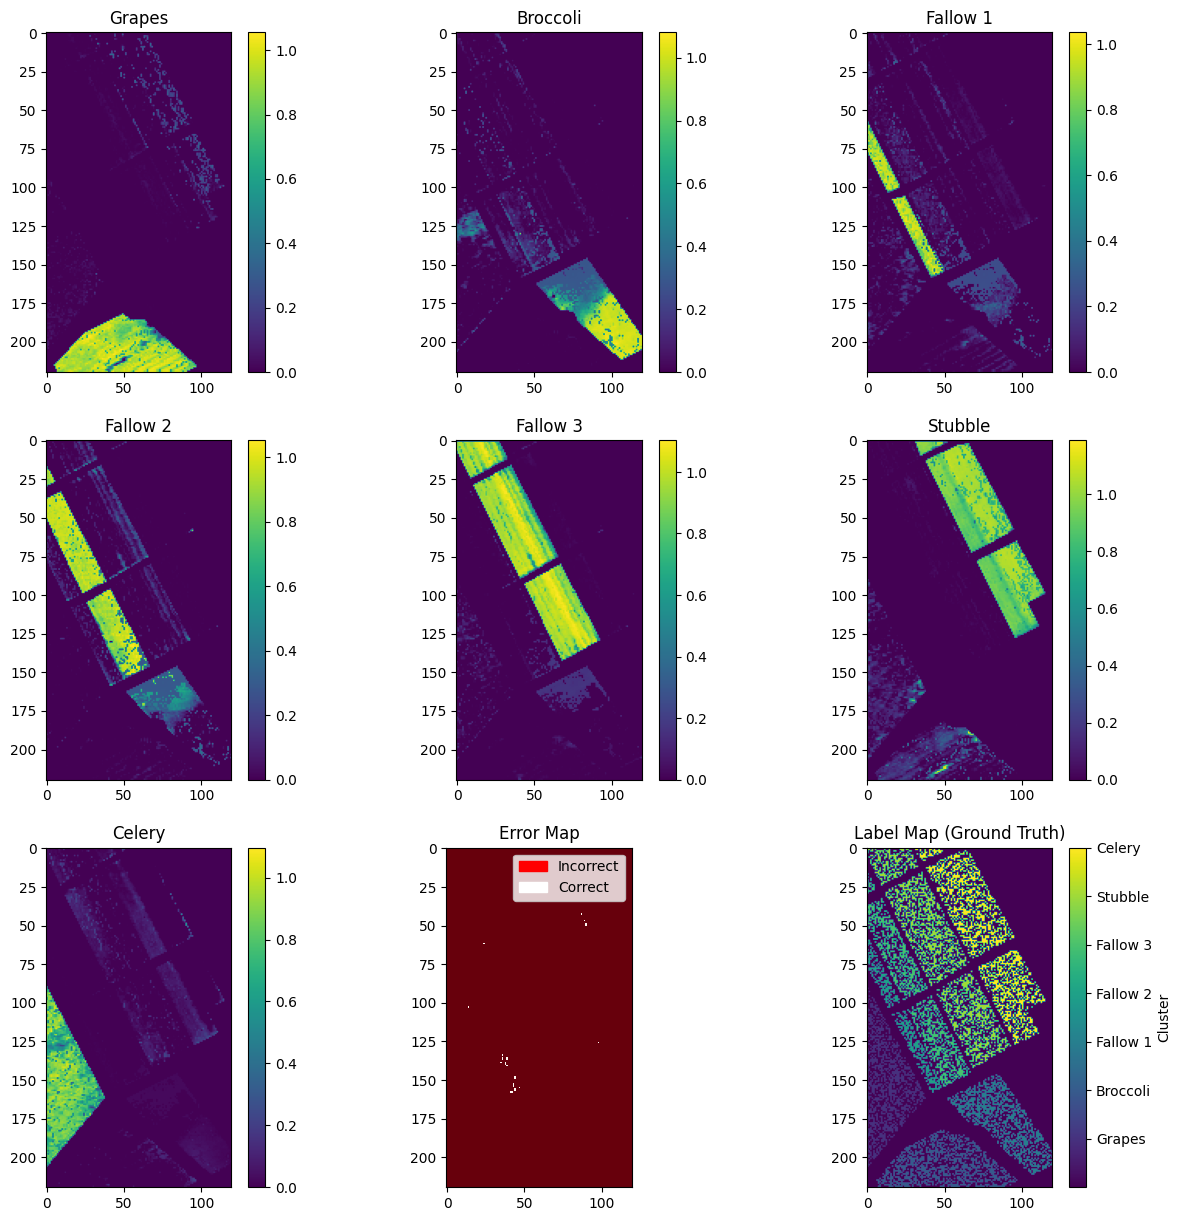

Average Reconstruction Error: 234651.49870931418


In [14]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative")
plot_abundance_map(abundance_map, labels, materials)
print(f"Average Reconstruction Error: {reconstruction_error}")

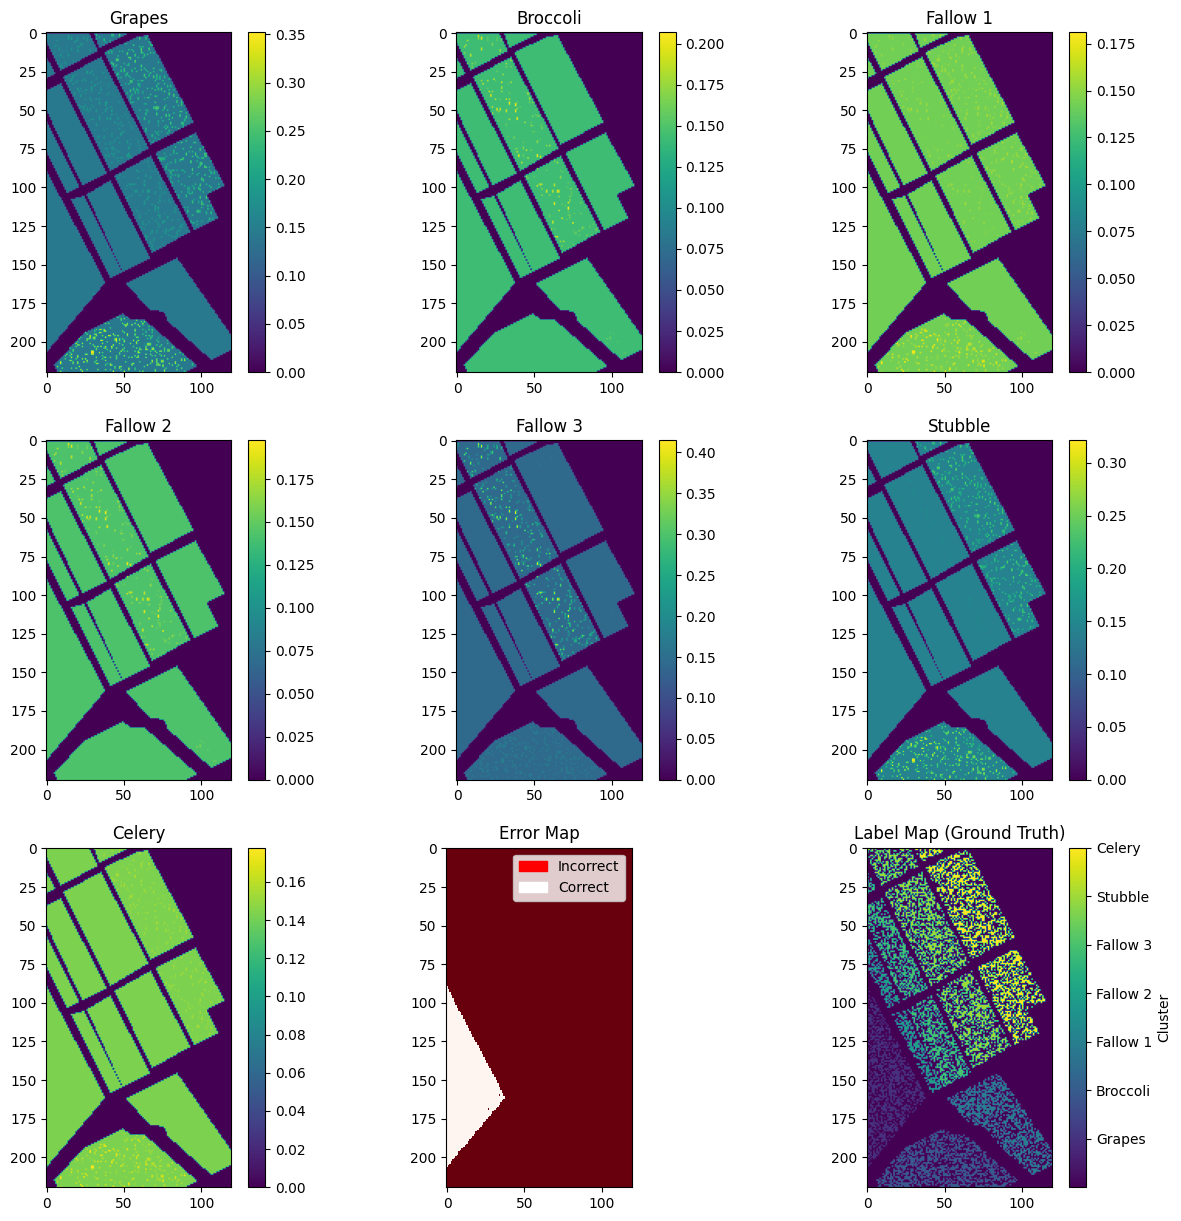

Average Reconstruction Error: 83294010.38232562


In [15]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Least Squares Non-Negative Sum-to-One")
plot_abundance_map(abundance_map, labels, materials)
print(f"Average Reconstruction Error: {reconstruction_error}")

/Users/michaeltheophanopoulos/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.986e+04, tolerance: 7.630e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michaeltheophanopoulos/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.656e+04, tolerance: 7.464e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michaeltheophanopoulos/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

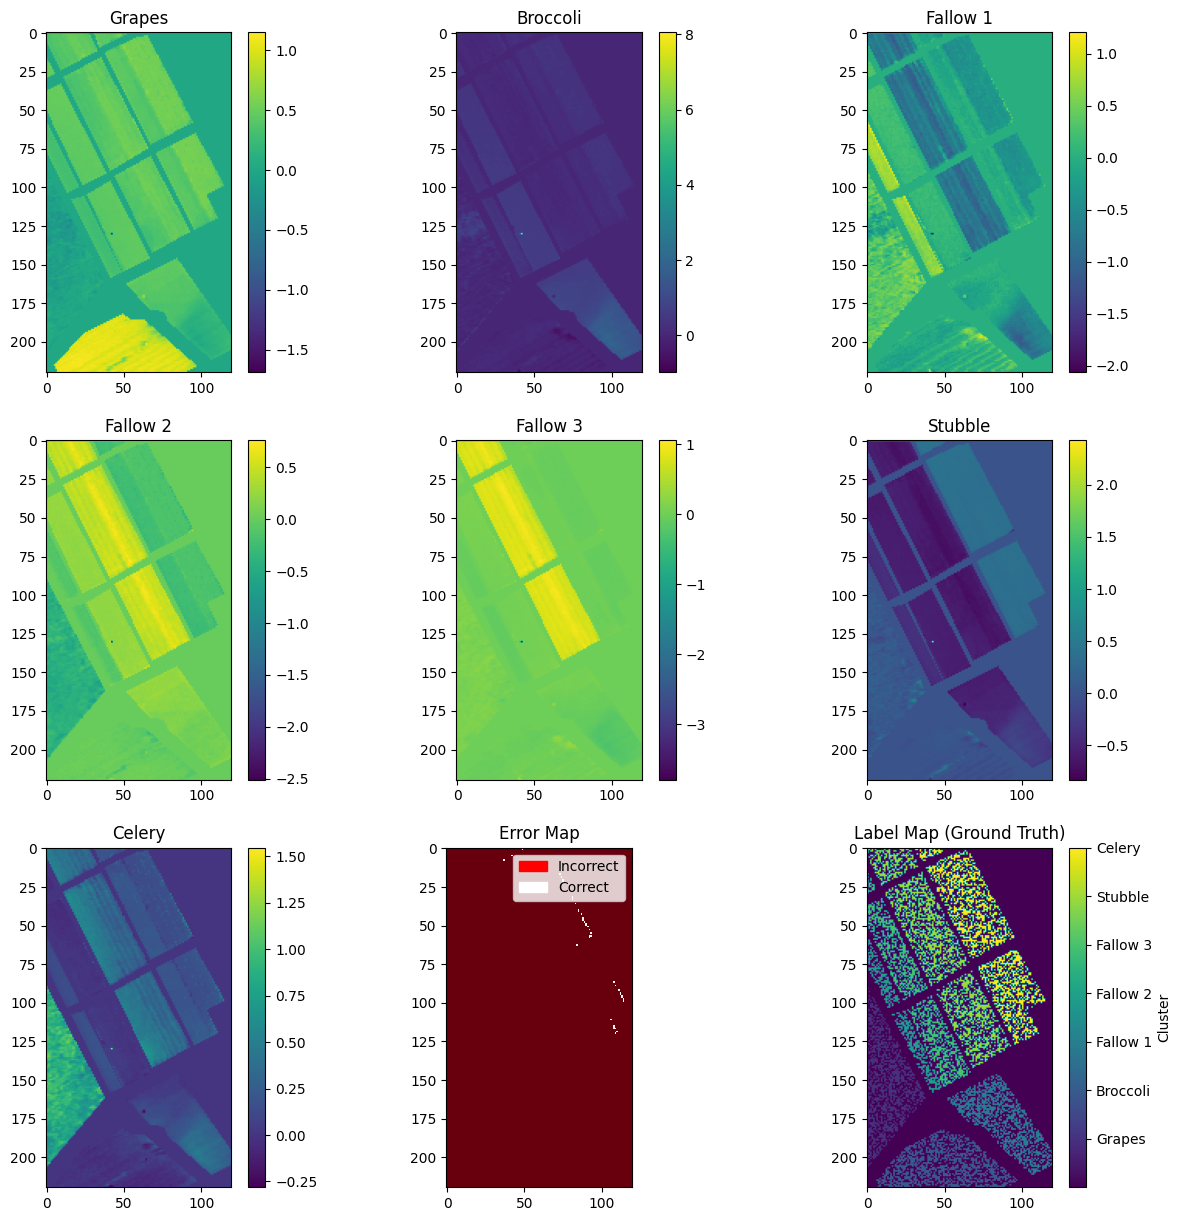

Average Reconstruction Error: 83197.26792407862


In [16]:
# Run the unmixing and plot the results
abundance_map, reconstruction_error = unmix_matrix(endmembers, HSI, labels, "Lasso")
plot_abundance_map(abundance_map, labels, materials)
print(f"Average Reconstruction Error: {reconstruction_error}")

#TODO: Add observations here